In [37]:
import os
import random

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt


import cv2
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)

set_seed(20)

# Preprocessing
Includes:
- Resizing images
- Augmentation
  - Rotation
  - Flipping vertically
  - Brightness adjustments
  - Contrast
  - Color enhancement

In [3]:
IMAGES_PATH = 'data/head_ct/'
LABELS_PATH = 'data/labels.csv'

## Loading labels

In [4]:
labels = pd.read_csv(LABELS_PATH)
labels.head()

,id,hemorrhage
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


The 2nd column name has an error: ' ' (space) in front of `hemorrhage`.

So instead of `hemorrhage` there is `_hemorrhage`

In [5]:
labels.rename(columns={' hemorrhage': 'hemorrhage'}, inplace=True)
labels.head()

,id,hemorrhage
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


## Loading images 
and resizing them accordingly

In [6]:
images = []
for file in os.listdir(IMAGES_PATH):
    if file.endswith('.png'):
        images.append(IMAGES_PATH + file)
        

In [7]:
images.sort()

In [8]:
len(images)

200

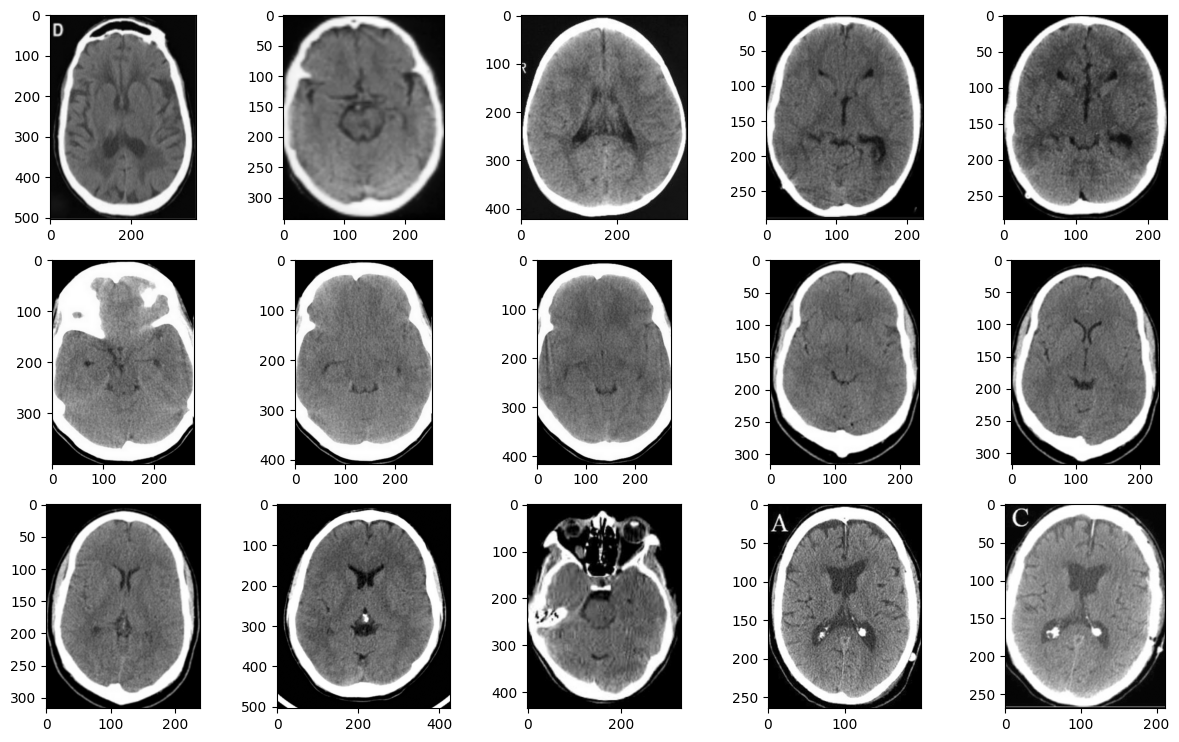

In [9]:
# Display example of normal images
normal = labels[labels['hemorrhage'] == 0]

rows, columns = 3, 5
fig = plt.figure(figsize=(15, 9))
for i in range(1, rows * columns + 1):
    fig.add_subplot(rows, columns, i)
    image = cv2.imread(images[normal.index[i]], cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
plt.show()


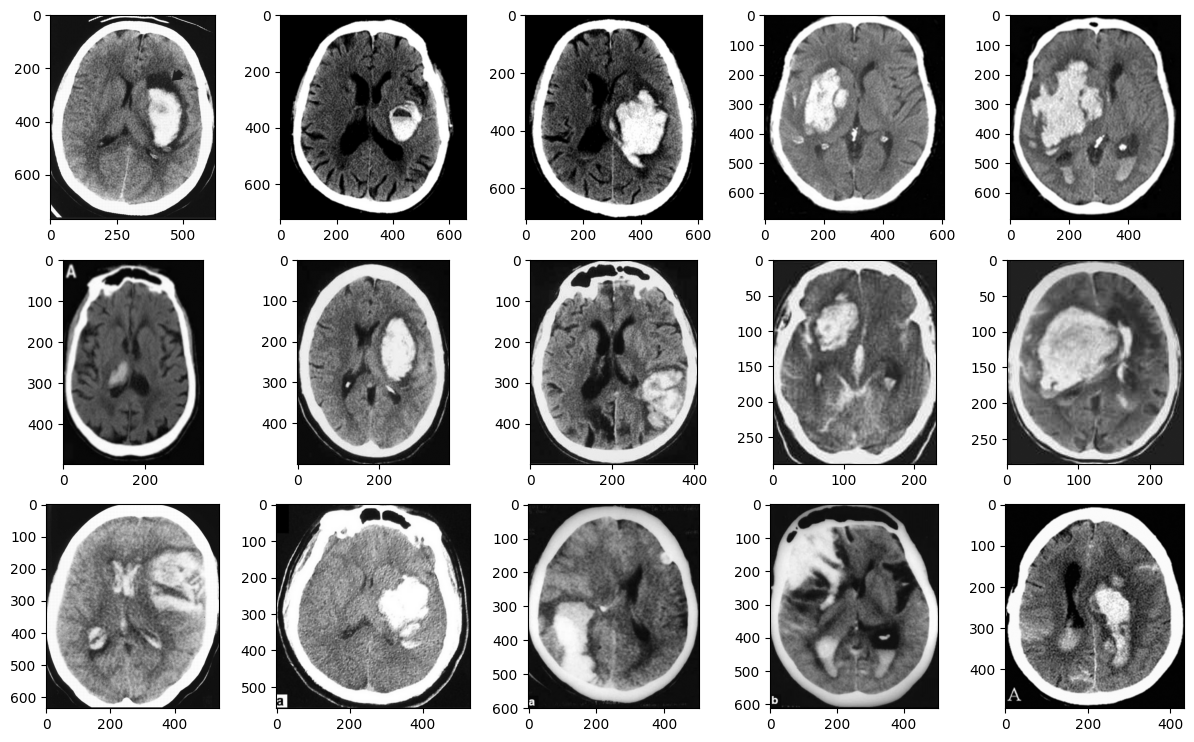

In [10]:
# Display example of images with hemorrhage
hemorrhage = labels[labels['hemorrhage'] == 1]

rows, columns = 3, 5
fig = plt.figure(figsize=(15, 9))
for i in range(1, rows * columns + 1):
    fig.add_subplot(rows, columns, i)
    image = cv2.imread(images[hemorrhage.index[i]], cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
plt.show()

Since we have small dataset, to improve accuracy, we have to apply data augmentation.
It helps with:
- **Prevents overfitting** - model learns from features rather than memorizing?
- **Improves robustness** - real data are not perfect, so simple rotations or vertical (not horizontal!) flips are helpful
- **Simulates real life condition**

Source: https://pmc.ncbi.nlm.nih.gov/articles/PMC10027281/#Tab1

In [11]:
def apply_augmentation(image):
    
    angle=random.randint(-20,20)
    augmented_image=image.rotate(angle)
    
    if(random.random()>0.5):
        augmented_image=augmented_image.transpose(Image.FLIP_LEFT_RIGHT)
    
    brightness_factor=random.uniform(0.85,1.15)
    enhanced_image= ImageEnhance.Brightness(augmented_image).enhance(brightness_factor)
    
    contrast_factor = random.uniform(0.85, 1.15)
    enhanced_image = ImageEnhance.Contrast(enhanced_image).enhance(contrast_factor)
    
    color_image = ImageEnhance.Color(enhanced_image).enhance(random.uniform(0.8, 1.2))
    
    # nearest-neighbor
    
    scale_factor=random.uniform(0.8,1.2)
    new_size=(int(color_image.width * scale_factor),int(color_image.height * scale_factor))
    
    new_image=color_image.resize(new_size,Image.NEAREST)
    
    
    return new_image

In [12]:
# Augmenting the dataset
augmented_images = []
augmented_labels = pd.DataFrame(columns=['id', 'hemorrhage'])

AUGMENTATIONS_PER_IMAGE = 5

for image in images:
    for i in range(AUGMENTATIONS_PER_IMAGE):
        pil_image = Image.open(image)
        augmented_image = apply_augmentation(pil_image)
        augmented_images.append(augmented_image)
        
        # Get the label for the original image
        image_index = images.index(image)
        label = labels.iloc[image_index]['hemorrhage']

        augmented_labels.loc[len(augmented_labels)] = [f"A{i:03d}",label] # in case of saving the image, the label is set here


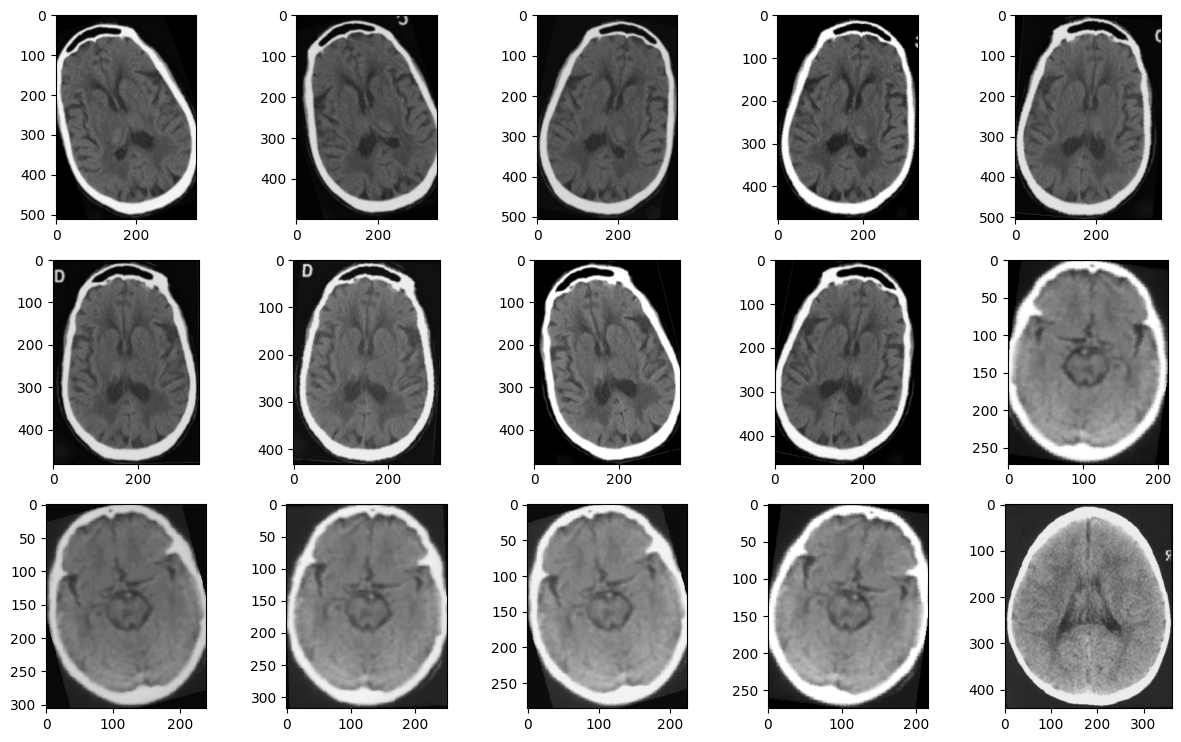

In [14]:
# Display example of augmented images without hemorrhage
hemorrhage = augmented_labels[augmented_labels['hemorrhage'] == 0]

rows, columns = 3, 5
fig = plt.figure(figsize=(15, 9))
for i in range(1, rows * columns + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(augmented_images[hemorrhage.index[i]], cmap='gray')
plt.show()

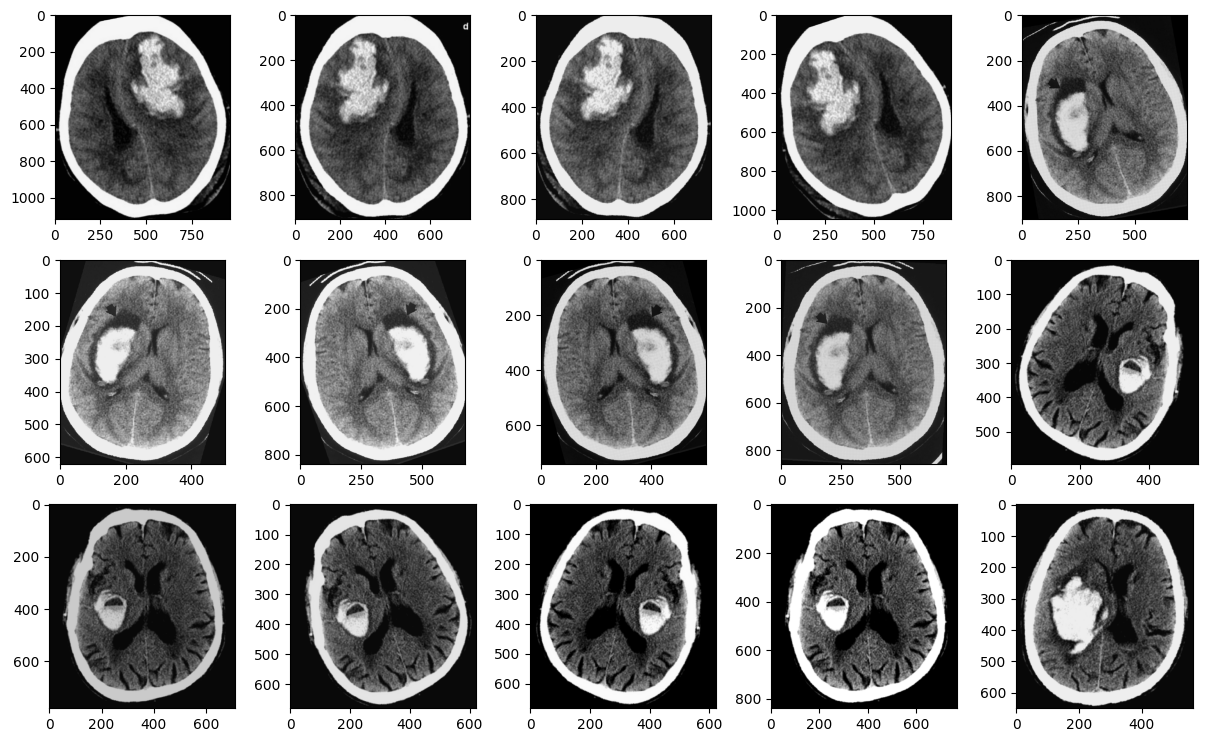

In [15]:
# Display example of augmented images with hemorrhage
hemorrhage = augmented_labels[augmented_labels['hemorrhage'] == 1]

rows, columns = 3, 5
fig = plt.figure(figsize=(15, 9))
for i in range(1, rows * columns + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(augmented_images[hemorrhage.index[i]], cmap='gray')
plt.show()

## 4.2 Modeling and Evaluation

First we change the pictures to numpy arrays, and then we split them between test/train.

In [16]:
x = []
y = []
IMG_SIZE = 224 # supposedly standard size..

for idx, path in enumerate(images):
    # loading
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    #normalizing
    img = img.astype('float32') / 255.0 # values should be about 0.5 so it is between 0 and 1, original was 128
    
    x.append(img)
    y.append(labels.iloc[idx]['hemorrhage'])


In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2, 
    random_state=20,
    stratify=y 
)

First we will try the Logistic Regression model and see what the Accuracy, precision and recall stats are for that.

In [18]:
x_train = np.array(x_train)
x_test  = np.array(x_test)

x_train_flat = x_train.reshape(len(x_train), -1)
x_test_flat  = x_test.reshape(len(x_test), -1)

log_reg = LogisticRegression(max_iter=1000, random_state=23)
log_reg.fit(x_train_flat, y_train)

y_pred_train = log_reg.predict(x_train_flat)
y_pred_test = log_reg.predict(x_test_flat)


In [19]:
print("Logistic Regression")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Test Precision:", precision_score(y_test, y_pred_test))
print("Test Recall:", recall_score(y_test, y_pred_test))

Logistic Regression
Train Accuracy: 1.0
Test Accuracy: 0.8
Test Precision: 0.7727272727272727
Test Recall: 0.85


Next model we will try is Random Forest.

In [20]:
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=3,
    random_state=20
)

rf.fit(x_train_flat, y_train)

,n_estimators,50
,criterion,'gini'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
rf_prediction_test = rf.predict(x_test_flat)
rf_prediction_train = rf.predict(x_train_flat)

In [22]:
rf_test_accuracy = accuracy_score(y_test, rf_prediction_test)
rf_test_precision = precision_score(y_test, rf_prediction_test)
rf_test_recall = recall_score(y_test, rf_prediction_test)

rf_train_accuracy = accuracy_score(y_train, rf_prediction_train)
rf_train_precision = precision_score(y_train, rf_prediction_train)
rf_train_recall = recall_score(y_train, rf_prediction_train)

In [23]:
print("Random Forest")
print("Train Accuracy:", accuracy_score(y_train, rf_prediction_train))
print("Test Accuracy:", accuracy_score(y_test, rf_prediction_test))
print("Test Precision:", precision_score(y_test, rf_prediction_test))
print("Test Recall:", recall_score(y_test, rf_prediction_test))

Random Forest
Train Accuracy: 0.96875
Test Accuracy: 0.825
Test Precision: 0.782608695652174
Test Recall: 0.9


The overfitting is still very high, although a bit better than in Logistic regression. 

Lets check one more model and see which of the three is the best one.

As our last model, we chose CNN. 

In [24]:
class CTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = Image.fromarray((self.images[idx]*255).astype('uint8'))  # back to PIL Image
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [47]:
transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

batch_size = 8

full_train_dataset = CTDataset(x_train, y_train, transform=transform)
test_dataset = CTDataset(x_test, y_test, transform=transform)

# 80% train, 20% validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(), #original size 224, getting halved by MaxPool2d
            nn.MaxPool2d(2),  # 112
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 28
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:

# model = SimpleCNN().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# num_epochs = 10

# best_loss = float('inf')
# patience = 7
# counter = 0

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     correct = 0
#     total = 0
    
#     for imgs, labels in train_loader:
#         imgs, labels = imgs.to(device), labels.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(imgs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         train_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)

#         # if train_loss/len(train_loader) < loss_stop:
#         #     break
    
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")

Epoch 1/10, Loss: 0.6920, Accuracy: 0.5563
Epoch 2/10, Loss: 0.5873, Accuracy: 0.7125
Epoch 3/10, Loss: 0.4685, Accuracy: 0.7500
Epoch 4/10, Loss: 0.3795, Accuracy: 0.8313
Epoch 5/10, Loss: 0.3201, Accuracy: 0.8875
Epoch 6/10, Loss: 0.2740, Accuracy: 0.8938
Epoch 7/10, Loss: 0.2216, Accuracy: 0.9125
Epoch 8/10, Loss: 0.2204, Accuracy: 0.8812
Epoch 9/10, Loss: 0.1563, Accuracy: 0.9375
Epoch 10/10, Loss: 0.1217, Accuracy: 0.9688


In [50]:

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100


best_loss = float('inf')
patience = 7
counter = 0

for epoch in range(num_epochs):
    # -------- TRAIN --------
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = correct / total

    # -------- VALIDATE --------
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # -------- EARLY STOPPING --------
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}")


Epoch 1/100, Train Loss: 0.7068, Train Acc: 0.5234, Val Loss: 0.6954
Epoch 2/100, Train Loss: 0.6084, Train Acc: 0.6719, Val Loss: 0.5467
Epoch 3/100, Train Loss: 0.4139, Train Acc: 0.7969, Val Loss: 0.3750
Epoch 4/100, Train Loss: 0.3443, Train Acc: 0.8203, Val Loss: 0.3228
Epoch 5/100, Train Loss: 0.2784, Train Acc: 0.8984, Val Loss: 0.4332
Epoch 6/100, Train Loss: 0.2697, Train Acc: 0.8906, Val Loss: 0.2812
Epoch 7/100, Train Loss: 0.1938, Train Acc: 0.9219, Val Loss: 0.2733
Epoch 8/100, Train Loss: 0.2135, Train Acc: 0.9062, Val Loss: 0.2992
Epoch 9/100, Train Loss: 0.1189, Train Acc: 0.9609, Val Loss: 0.3163
Epoch 10/100, Train Loss: 0.1018, Train Acc: 0.9609, Val Loss: 0.3739
Epoch 11/100, Train Loss: 0.1005, Train Acc: 0.9688, Val Loss: 0.3598
Epoch 12/100, Train Loss: 0.0799, Train Acc: 0.9688, Val Loss: 0.3644
Epoch 13/100, Train Loss: 0.0512, Train Acc: 0.9922, Val Loss: 0.3784
Early stopping triggered


In [51]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print("Test Precision:", precision_score(all_labels, all_preds))
print("Test Recall:", recall_score(all_labels, all_preds))

Test Accuracy: 0.825
Test Precision: 0.8823529411764706
Test Recall: 0.75


Pri accuracy máme rozdiel 0.03, čo nie je príliš veľký rozdiel a nejedná sa o overfitting. Závoreň je to najlepší zo všetkých troch modelov, podľa jeho výsledkov

VÝSLEDOK - najvhodnejší z troch modelov (RF, LR a CNN) je podľa výsledkov CNN. 